# Demonstration of naive parallelization by python

In [1]:
import multiprocessing as mp
import numpy as np

/tmp/ipykernel_3902371/1256496167.py:30: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


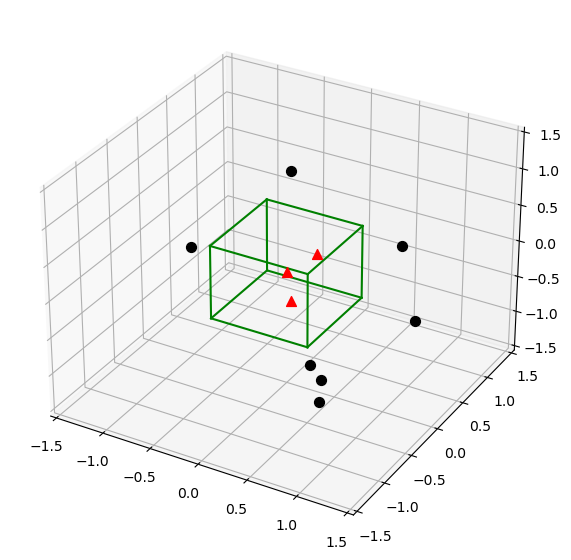

In [3]:

def parzen_estimation(x_samples, point_x, h):
    """
    Implementation of a hypercube kernel for Parzen-window estimation.
 
    Keyword arguments:
        x_sample:training sample, 'd x 1'-dimensional numpy array
        x: point x for density estimation, 'd x 1'-dimensional numpy array
        h: window width
 
    Returns the predicted pdf as float.
 
    """
    k_n = 0
    for row in x_samples:
        x_i = (point_x - row[:,np.newaxis]) / (h)
        for row in x_i:
            if np.abs(row) > (1/2):
                break
        else: # "completion-else"*
            k_n += 1
    return (k_n / len(x_samples)) / (h**point_x.shape[1])

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from itertools import product, combinations
%matplotlib inline 

fig = plt.figure(figsize=(7,7))
ax = fig.gca(projection='3d')
#ax.set_aspect("equal")
 
# Plot Points
 
# samples within the cube
X_inside = np.array([[0,0,0],[0.2,0.2,0.2],[0.1, -0.1, -0.3]])
 
X_outside = np.array([[-1.2,0.3,-0.3],[0.8,-0.82,-0.9],[1, 0.6, -0.7],
                  [0.8,0.7,0.2],[0.7,-0.8,-0.45],[-0.3, 0.6, 0.9],
                  [0.7,-0.6,-0.8]])
 
for row in X_inside:
    ax.scatter(row[0], row[1], row[2], color="r", s=50, marker='^')
 
for row in X_outside:    
    ax.scatter(row[0], row[1], row[2], color="k", s=50)
 
# Plot Cube
h = [-0.5, 0.5]
for s, e in combinations(np.array(list(product(h,h,h))), 2):
    if np.sum(np.abs(s-e)) == h[1]-h[0]:
        ax.plot3D(*zip(s,e), color="g")
 
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_zlim(-1.5, 1.5)
 
plt.show()


point_x = np.array([[0],[0],[0]])
X_all = np.vstack((X_inside,X_outside))

In [4]:
point_x = np.array([[0],[0],[0]])
X_all = np.vstack((X_inside,X_outside))
 
print('p(x) =', parzen_estimation(X_all, point_x, h=1))

p(x) = 0.3


In [5]:
np.random.seed(123)
 
# Generate random 2D-patterns
mu_vec = np.array([0,0])
cov_mat = np.array([[1,0],[0,1]])
x_2Dgauss = np.random.multivariate_normal(mu_vec, cov_mat, 10000)


In [6]:
from scipy.stats import multivariate_normal
var = multivariate_normal(mean=[0,0], cov=[[1,0],[0,1]])
print('actual probability density:', var.pdf([0,0]))

actual probability density: 0.15915494309189535


In [7]:
def parzen_estimation(x_samples, point_x, h):
    k_n = 0
    for row in x_samples:
        x_i = (point_x - row[:,np.newaxis]) / (h)
        for row in x_i:
            if np.abs(row) > (1/2):
                break
        else: # "completion-else"*
            k_n += 1
    return (h, (k_n / len(x_samples)) / (h**point_x.shape[1]))

In [8]:
def serial(samples, x, widths):
    return [parzen_estimation(samples, x, w) for w in widths]
 
def multiprocess(processes, samples, x, widths):
    pool = mp.Pool(processes=processes)
    results = [pool.apply_async(parzen_estimation, args=(samples, x, w)) for w in widths]
    results = [p.get() for p in results]
    results.sort() # to sort the results by input window width
    return results

In [9]:
widths = np.arange(0.1, 1.3, 0.1)
point_x = np.array([[0],[0]])
results = []
 
results = multiprocess(4, x_2Dgauss, point_x, widths)
 
for r in results:
    print('h = %s, p(x) = %s' %(r[0], r[1]))

h = 0.1, p(x) = 0.016
h = 0.2, p(x) = 0.0305
h = 0.30000000000000004, p(x) = 0.04499999999999999
h = 0.4, p(x) = 0.06175
h = 0.5, p(x) = 0.078
h = 0.6, p(x) = 0.09116666666666667
h = 0.7000000000000001, p(x) = 0.106
h = 0.8, p(x) = 0.117375
h = 0.9, p(x) = 0.13266666666666668
h = 1.0, p(x) = 0.1445
h = 1.1, p(x) = 0.1570909090909091
h = 1.2000000000000002, p(x) = 0.16849999999999996


In [10]:
widths = np.linspace(1.0, 1.2 , 100)

In [11]:
import timeit
 
mu_vec = np.array([0,0])
cov_mat = np.array([[1,0],[0,1]])
n = 10000
 
x_2Dgauss = np.random.multivariate_normal(mu_vec, cov_mat, n)
 
benchmarks = []
 
benchmarks.append(timeit.Timer('serial(x_2Dgauss, point_x, widths)', 
        'from __main__ import serial, x_2Dgauss, point_x, widths').timeit(number=1))
 
benchmarks.append(timeit.Timer('multiprocess(2, x_2Dgauss, point_x, widths)', 
        'from __main__ import multiprocess, x_2Dgauss, point_x, widths').timeit(number=1))
 
benchmarks.append(timeit.Timer('multiprocess(3, x_2Dgauss, point_x, widths)', 
        'from __main__ import multiprocess, x_2Dgauss, point_x, widths').timeit(number=1))
 
benchmarks.append(timeit.Timer('multiprocess(4, x_2Dgauss, point_x, widths)', 
        'from __main__ import multiprocess, x_2Dgauss, point_x, widths').timeit(number=1))
 
benchmarks.append(timeit.Timer('multiprocess(6, x_2Dgauss, point_x, widths)', 
        'from __main__ import multiprocess, x_2Dgauss, point_x, widths').timeit(number=1))


In [12]:
import platform
 
def print_sysinfo():
 
    print('\nPython version  :', platform.python_version())
    print('compiler        :', platform.python_compiler())
 
    print('\nsystem     :', platform.system())
    print('release    :', platform.release())
    print('machine    :', platform.machine())
    print('processor  :', platform.processor())
    print('CPU count  :', mp.cpu_count())
    print('interpreter:', platform.architecture()[0])
    print('\n\n')

In [13]:
from matplotlib import pyplot as plt
import numpy as np
 
def plot_results():
    bar_labels = ['serial', '2', '3', '4', '6']
 
    fig = plt.figure(figsize=(10,8))
 
    # plot bars
    y_pos = np.arange(len(benchmarks))
    plt.yticks(y_pos, bar_labels, fontsize=16)
    bars = plt.barh(y_pos, benchmarks,
         align='center', alpha=0.4, color='g')
 
    # annotation and labels
 
    for ba,be in zip(bars, benchmarks):
        plt.text(ba.get_width() + 1.4, ba.get_y() + ba.get_height()/2,
            '{0:.2%}'.format(benchmarks[0]/be), 
            ha='center', va='bottom', fontsize=11)
 
    plt.xlabel('time in seconds for n=%s' %n, fontsize=14)
    plt.ylabel('number of processes', fontsize=14)
    t = plt.title('Serial vs. Multiprocessing via Parzen-window estimation', fontsize=18)
    plt.ylim([-1,len(benchmarks)+0.5])
    plt.xlim([0,max(benchmarks)*1.1])
    plt.vlines(benchmarks[0], -1, len(benchmarks)+0.5, linestyles='dashed')
    plt.grid()
 
    plt.show()

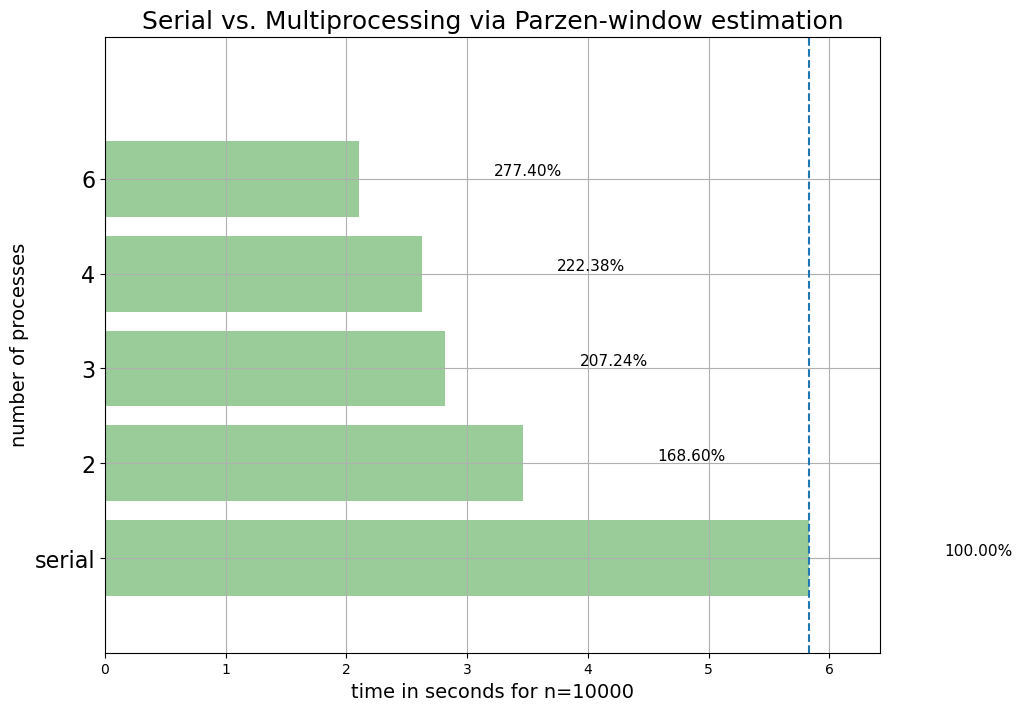


Python version  : 3.9.13
compiler        : GCC 11.2.0

system     : Linux
release    : 5.15.0-69-generic
machine    : x86_64
processor  : x86_64
CPU count  : 8
interpreter: 64bit





In [14]:
plot_results()
print_sysinfo()